## Using scMKL with single-cell ATAC data
To run tutorials, install `plotnine` and `jupyter` into your scMKL env with `pip install plotnine jupyter`.
Here we will run scMKL on a subset of the MCF-7 data (1,000 cells x 206,167 peaks) using Hallmark groupings.

### Importing Modules
Data is read-in and saved using numpy and pickle modules.

In [1]:
import scmkl

# Packages needed to import data
import numpy as np
from scipy.sparse import load_npz

# Modules for viewing results
import pandas as pd
from plotnine import *

### Reading in Data
There are four pieces of data (per modality) required for scMKL:
- The data matrix itself with cells as rows and features as columns.
    - Can be either a Numpy array or SciPy sparse array (scipy.sparse.csc_array is the recommended format).  
- The sample labels in a Numpy array. To perform group lasso, these labels must be binary.
- Feature names in a Numpy array. These are the names of the features corresponding with the data matrix columns.
- A dictionary with grouping data.  The keys are the names of the groups, and the values are the corresponding features.
    - Example: {Group1: [feature1, feature2, feature3], Group2: [feature4, feature5, feature6], ...}.
    - See `getting_ATAC_groupings.ipynb` for more information on creating peak sets.

In [2]:
# Reading in grouping dictionary from pickle file
group_dict = np.load('./data/ATAC_hallmark_groupings.pkl', allow_pickle = True)

# Reading in data to be analyzed
X = load_npz('./data/MCF7_ATAC_X.npz')
cell_labels = np.load('./data/MCF7_cell_labels.npy', allow_pickle = True)
feature_names = np.load('./data/MCF7_ATAC_feature_names.npy', allow_pickle = True)

# D is the number of dimensions per group
# Previous literature shows the calculation below yields optimal number of dimensions
D = int(np.sqrt(len(cell_labels)) * np.log(np.log(len(cell_labels))))

### Creating an AnnData Object
scMKL takes advantage of AnnData's flexible structure to create a straight-forward approach to running scMKL.
`create_adata` requires: 
- `X` : A data matrix of cells by features can be a `np.ndarray`, `scipy.sparse.csc_matrix` or `pandas.DataFrame.values` (sparse array recommended for large datasets).
- `feature_names` : A `np.ndarray` of feature names corresponding with the features in `X`.
- `cell_labels` : A `np.ndarray` of cell phenotypes corresponding with the cells in `X` (must be binary).
- `group_dict` : Dictionary containing feature grouping information.
    - Example: `{peakset: np.array(peak_1, peak_2, ..., peak_n)}`.
- `scale_data` : If False, `X` will not be log transformed and scaled.
- `split_data` : Either numpy array of precalculated train/test split for the cells or `None`.
    - If `None`, the train test split will be calculated with balanced classes.
- `D` : Number of dimension per group in Z matrix.
- `remove_features` : Bool whether to filter none intersecting features in `group_dict`, `X`, and `feature_names`.
- `random_state` : Integer used to set seed for reproducibilty.

In [3]:
adata = scmkl.create_adata(X = X, 
                         feature_names = feature_names, 
                         cell_labels = cell_labels, 
                         group_dict = group_dict,
                         scale_data = False, 
                         D = D, 
                         remove_features = True, 
                         random_state = 100)

         Columns with zero summed columns will not be removed
         To change this behavior, set scale_data to True


### Estimating Kernel Widths
`sigma` refers to kernel widths of kernels and should be estimated when running scMKL with `estimate_sigma()`:
- `adata` : `AnnData` created by `create_adata`
- `n_features` : Number of random features from the data to estimate sigmas for scalability

Returns adata object with sigma array in `adata.uns['sigma']`

In [4]:
adata = scmkl.estimate_sigma(adata, n_features = 200)

### Calculating Z
The Z matrices are a the Fourier transform of the grouped data matrix. This is calculated on training samples and testing samples separately. 

Here we calculate Z using the `calculate_z` function with:
- `adata` : Adata obj as created by `create_adata` with `'sigma'` key in `adata.uns`
- `n_features` : Number of random features to use when calculating Z for scalability

Returns Z matrices for training and testing in adata object with `adata.uns['Z_train']` and `adata.uns['Z_test']`

In [5]:
adata = scmkl.calculate_z(adata, n_features = 5000)

### Optimizing Sparsity
Sparsity (lambda) or alpha here, is the regularization coefficient that controls the pentalty to run with the model.

This will ultimately decide how many groups will be used in the final model.

We can calculate the best performing sparsity argument from the training data using cross-validation with `optimize_alpha`, which requires:
- `adata` : Anndata object with `'Z_train'` and `'Z_test'` keys in `adata.uns`.
- `group_size` : Argument describing how the features are grouped and should be two times `D`.
- `tfidf` : If set to `True`, data will be TFIDF transformed for each fold.
- `alpha_array` : Numpy array of all alpha values to be tested.
- `k` : number of folds to perform cross validation for.

Returns a single sparsity value as the optimal sparsity aregument for training the model.

**NOTE: This step take a while to run and may want to be skipped if running the model with multiple sparsity arguments.**

In [6]:
# Setting a list of alpha values to train the model with
alpha_list = np.round(np.linspace(2.2,0.05,10), 2)

# Calculating the best performing alpha from cross validation on training data
alpha_star = scmkl.optimize_alpha(adata = adata, group_size = 2 * D, tfidf = False, alpha_array = alpha_list, k = 4)

### Training and Evalutating Model
Here we will train and evaluate 10 models, each with a different `alpha`.

`alpha` (or lambda) is a regularization coefficient that deterimines how many groupings will be used to classify the test cells in the final model. Here, we will evalutate the model using a range of alphas (`alpha_list`) to get a range of selected groups.

In [7]:
results = scmkl.run(adata = adata, alpha_list = alpha_list)
results.keys()

  Evaluating model. Alpha: 2.2
  Evaluating model. Alpha: 1.96
  Evaluating model. Alpha: 1.72
  Evaluating model. Alpha: 1.48
  Evaluating model. Alpha: 1.24
  Evaluating model. Alpha: 1.01
  Evaluating model. Alpha: 0.77
  Evaluating model. Alpha: 0.53
  Evaluating model. Alpha: 0.29
  Evaluating model. Alpha: 0.05


dict_keys(['Metrics', 'Selected_groups', 'Norms', 'Predictions', 'Observed', 'Test_indices', 'Group_names', 'Models', 'Train_time', 'RAM_usage'])

### Model Performance and Top Groups per Alpha

   Alpha   AUROC  Number of Selected Groups  \
0   2.20  0.6983                          3   
1   1.96  0.7417                          5   
2   1.72  0.7811                          8   
3   1.48  0.8074                         11   
4   1.24  0.8320                         15   
5   1.01  0.8437                         17   
6   0.77  0.8489                         25   
7   0.53  0.8465                         34   
8   0.29  0.8427                         43   
9   0.05  0.7993                         47   

                            Top Group  
0         HALLMARK_HEDGEHOG_SIGNALING  
1         HALLMARK_HEDGEHOG_SIGNALING  
2         HALLMARK_HEDGEHOG_SIGNALING  
3          HALLMARK_KRAS_SIGNALING_DN  
4          HALLMARK_KRAS_SIGNALING_DN  
5          HALLMARK_KRAS_SIGNALING_DN  
6          HALLMARK_KRAS_SIGNALING_DN  
7          HALLMARK_KRAS_SIGNALING_DN  
8          HALLMARK_KRAS_SIGNALING_DN  
9  HALLMARK_INTERFERON_ALPHA_RESPONSE  


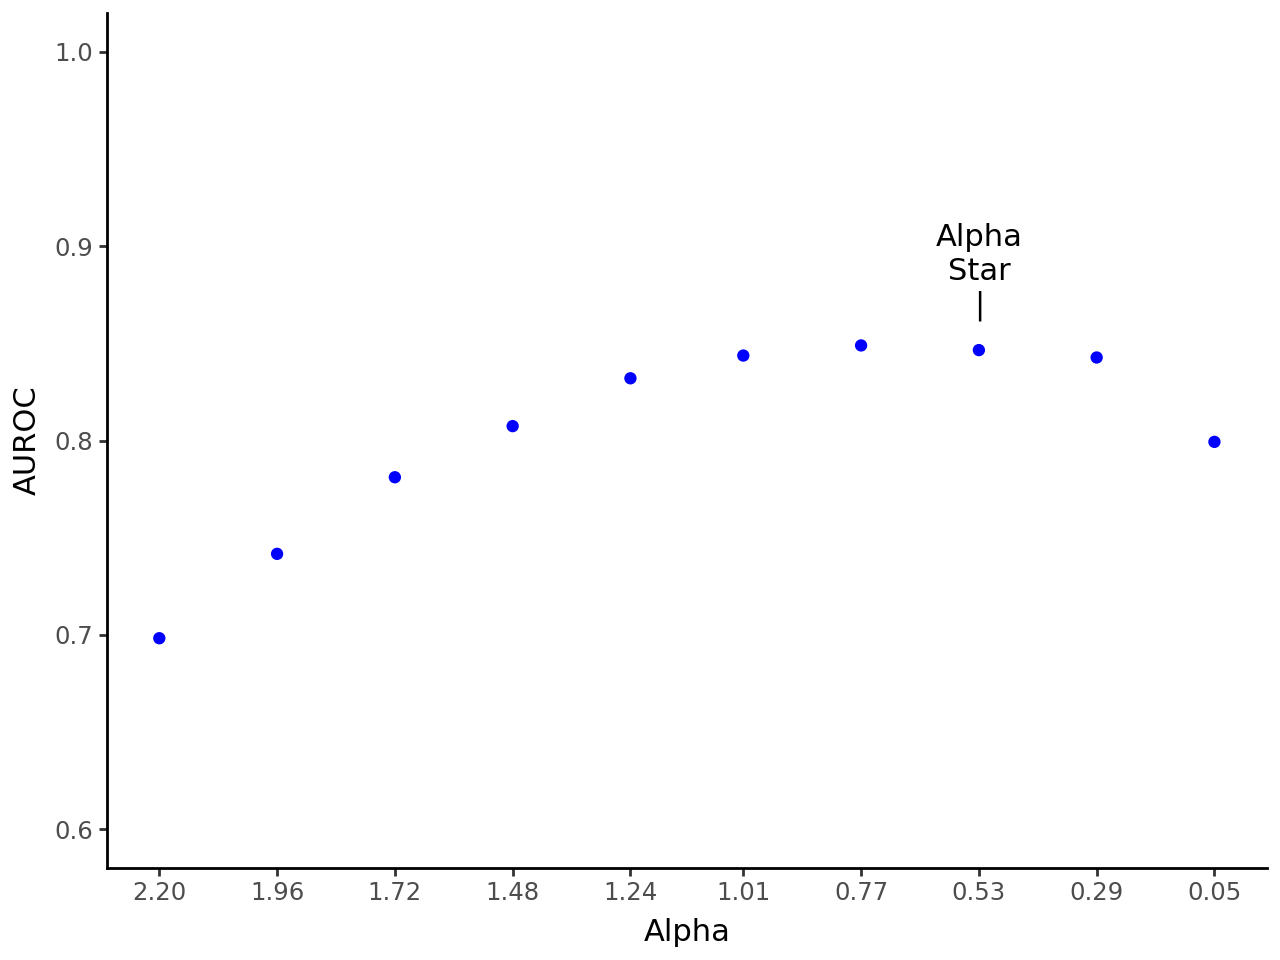

In [9]:
summary = {'Alpha' : [],
           'AUROC' : [],
           'Number of Selected Groups' : [],
           'Top Group' : []}

# Creating summary DataFrame for each model
for alpha in alpha_list:
    summary['Alpha'].append(alpha)
    summary['AUROC'].append(results['Metrics'][alpha]['AUROC'])
    summary['Number of Selected Groups'].append(len(results['Selected_groups'][alpha]))
    summary['Top Group'].append(*np.array(results['Group_names'])[np.where(results['Norms'][alpha] == max(results['Norms'][alpha]))])
summary = pd.DataFrame(summary)
alpha_star_auroc = float(summary[summary['Alpha'] == alpha_star]['AUROC'])

print(summary)

# Plotting AUROC from each alpha run
(ggplot(summary, aes(x = 'Alpha', y = 'AUROC')) 
 + geom_point(fill = 'blue', color = 'blue') 
 + theme_classic() 
 + ylim(0.6, 1)
 + scale_x_reverse(breaks = alpha_list)
 + annotate('text', x = alpha_star, y = alpha_star_auroc + 0.04, label='Alpha\nStar\n|')
 ).show()